In [1]:
import numpy as np 
import pandas as pd 

In [2]:
students = pd.read_csv("/content/students.csv")
exams = pd.read_csv("/content/exams.csv")
enrolments = pd.read_csv("/content/enrolements.csv")
rooms = pd.read_csv("/content/indexed_rooms.csv")
slots= pd.read_csv("/content/slots.csv")

In [3]:
class Exam:
    def __init__(self, exam_code, name, duration, department_code):
        self.code = exam_code
        self.name = name
        self.duration = duration
        self.duration_min = 0
        self.dep_code = department_code
        self.conflicts = 0
        self.exam_conflicts = set()
        self.priority = 0
        self.slot = -1
        self.student_codes = []
        self.students = []
        self.rooms = []
        self.room_assigned = False
        self.access_requirement = False
        self.students_with_access_needs = []
        self.students_assigned = 0

class Student:
    def __init__(self, student_code, course_code, accessibility_need):
        self.code = student_code
        self.course_code = course_code
        self.accessibility_need = accessibility_need
        self.exams = []
        self.exam_codes = []

class Enrolment:
    def __init__(self, student_code, exam_code):
        self.student_code = student_code
        self.exam_code = exam_code

class Room:
    def __init__(self, index, room_code, capacity, accessible):
        self.index = index
        self.code = room_code
        self.capacity = capacity
        self.status = False
        self.accessible = accessible
        self.seats_occupied = 0
class Slot:
    def __init__(self, index, date, day, type):
        self.index = index
        self.date = date
        self.day = day
        self.type = type
        self.exams = []
        self.student_count = 0

In [4]:
exam_objects = [Exam(**kwargs) for kwargs in exams.to_dict(orient='records')]

student_objects = [Student(**kwargs) for kwargs in students.to_dict(orient='records')]

enrolment_objects = [Enrolment(**kwargs) for kwargs in enrolments.to_dict(orient='records')]

room_objects = [Room(**kwargs) for kwargs in rooms.to_dict(orient='records')]

slot_objects = [Slot(**kwargs) for kwargs in slots.to_dict(orient='records')]

In [5]:
for i in enrolment_objects:
    for j in student_objects:
        if j.code == i.student_code:
            j.exam_codes.append(i.exam_code)

In [6]:
for i in student_objects:
    for j in exam_objects:
        for k in i.exam_codes:
            if k == j.code:
                i.exams.append(j)

In [7]:
for i in enrolment_objects:
    for j in exam_objects:
        if j.code == i.exam_code:
            j.student_codes.append(i.student_code)

In [8]:
for i in exam_objects:
    for j in student_objects:
        for k in i.student_codes:
            if k == j.code:
                i.students.append(j)

In [9]:
for i in exam_objects:
    for j in i.students:
        if j.accessibility_need == True:
            i.access_requirement = True
            i.students_with_access_needs.append(j)

In [10]:
def getRoomKey(obj):
    return obj.capacity

In [11]:
def hhToSeconds(s):
    t = 0
    splitTime = s.split(':')
    t = 60 * int(splitTime[0]) + int(splitTime[1])
    return t

In [12]:
for i in exam_objects:
    i.duration_min = hhToSeconds(str(i.duration))

In [13]:
def degreeOfConflict(exam):
    s = set()
    for i in exam.students:
        for j in i.exams:
            if exam.code != j.code:
                s.add(j)
    exam.exam_conflicts = s
    return len(s)

In [14]:
for i in exam_objects:
    i.conflicts = degreeOfConflict(i)

In [15]:
def partialExamOrdering():
    sup = np.zeros(len(exam_objects))
    for i in range(len(exam_objects)):
        for j in range(len(exam_objects)):
            if exam_objects[i].conflicts > exam_objects[j].conflicts:
                sup[i] = sup[i] + 1
                continue
            elif exam_objects[i].conflicts < exam_objects[j].conflicts:
                sup[j] = sup[j] + 1
                continue
            if len(exam_objects[i].students) > len(exam_objects[j].students):
                sup[i] = sup[i] + 1
                continue
            elif len(exam_objects[i].students) < len(exam_objects[j].students):
                sup[j] = sup[j] + 1
                continue
            if exam_objects[i].duration_min > exam_objects[j].duration_min:
                sup[i] = sup[i] + 1
                continue
            elif exam_objects[i].duration_min < exam_objects[j].duration_min:
                sup[j] = sup[j] + 1
                continue
            if len(exam_objects[i].students_with_access_needs) > len(exam_objects[j].students_with_access_needs):
                sup[i] = sup[i] + 1
                continue
            elif len(exam_objects[i].students_with_access_needs) < len(exam_objects[j].students_with_access_needs):
                sup[j] = sup[j] + 1
                continue
            if exam_objects[i].code > exam_objects[j].code:
                sup[j] = sup[j] + 1
                continue
            elif exam_objects[i].code < exam_objects[j].code:
                sup[i] = sup[i] + 1
                continue
    return sup                               

In [16]:
def totalConflictsForExams():
    partialExamOrder = partialExamOrdering()
    for i in range(len(exam_objects)):
        exam_objects[i].priority = partialExamOrder[i]  

In [17]:
def getKey(obj):
    return obj.priority

In [18]:
pheromoneMatrix = np.zeros((len(exam_objects), len(slot_objects), len(room_objects)))

def updatePheromoneMatrix(t_min, t_max, EVAPORATION_RATE):
    for i in range(len(exam_objects)):
        for j in range(len(slot_objects)):
            for k in range(len(room_objects)):
                if exam_objects[i].slot.index == slot_objects[j].index and room_objects[k] in exam_objects[i].rooms:
                    pheromoneMatrix[i][j][k] = (1 - EVAPORATION_RATE) * pheromoneMatrix[i][j][k] + 1
                else:
                    pheromoneMatrix[i][j][k] = (1 - EVAPORATION_RATE) * pheromoneMatrix[i][j][k]
                if pheromoneMatrix[i][j][k] < t_min:
                    pheromoneMatrix[i][j][k] = t_min
                elif pheromoneMatrix[i][j][k] > t_max:
                    pheromoneMatrix[i][j][k] = t_max
    
def initPheromoneMatrix(exams, slots, rooms, value):
    for i in range(len(exams)):
        for j in range(len(slots)):
            for k in range(len(rooms)):
                pheromoneMatrix[i][j][k] = value
       

In [19]:
heuristicsMatrix = np.zeros((len(exam_objects), len(slot_objects), len(room_objects)))

def initHeuristicsMatrix(exams, slots, rooms):
    for i in range(len(exams)):
        for j in range(len(slots)):
            for k in range(len(rooms)):
                heuristicsMatrix[i][j][k] = 1


In [20]:
roomCapacityMatrix = np.zeros((len(slot_objects), len(room_objects)))

def initRoomCapacityMatrixMatrix(exams, slots, rooms):
    for j in range(len(slots)):
        for k in range(len(rooms)):
            roomCapacityMatrix[j][k] = room_objects[k].capacity
                
                    

In [21]:
def checkForHardConstraintViolations(exam, slot, room):
    score = 0
    for i in exam.exam_conflicts:
            if i.slot != -1:
                if i.slot.index == slot.index:
                    score += 4
                elif np.abs(i.slot.index - slot.index) < 2:
                    score += 4
    if slot.day == "Saturday" and slot.type == "Evening":
        score += 4
    if slot.type == "Evening" and exam.duration_min > 90:
        score += 4
    if len(exam.students) + slot.student_count > 2653:
        score += 4
    if len(exam.students) > room.capacity:
        score += 4
    if exam.access_requirement and room.accessible == False:
        score += 4
    return score
                    

In [22]:
def numIncentive(exam, slot, room):
    score = 0
    if slot.type == "Evening" and exam.duration_min <= 90:
        score += 4
    return 0

In [23]:
def checkForSoftConstraintViolations(exam, slot, room):
    score = 0
    for i in exam.exam_conflicts:
        if i.slot != -1:
            if np.abs(i.slot.index - slot.index) < 3:
                score += 1
    return score

In [24]:
def findForbiddenSlots(exam):
    forbiddenSlots = set()
    forbiddenSlots.add(slot_objects[11])
    for i in exam.exam_conflicts:
        if i.slot != -1 and i.code != exam.code:
            forbiddenSlots.add(i.slot)
    return forbiddenSlots

In [25]:
def numAdditionalViolations(exam, slot, room):
    score = 0
    score += checkForHardConstraintViolations(exam, slot, room)
    score += checkForSoftConstraintViolations(exam, slot, room)
    return score

In [26]:
def pheroHeuristicSummation(examIndex, slotIndex, roomIndex, alpha, beta):
    sum = 0
    for j in range(len(slot_objects)):
        for k in range(len(room_objects)):
            if j != slotIndex and k != roomIndex:
                sum += (pheromoneMatrix[examIndex][j][k]**alpha) * (heuristicsMatrix[examIndex][j][k]**beta)
    return sum

In [27]:
def chooseSlot(examIndex, exam, slots, rooms, alpha, beta):
    slot = 0
    room = []
    desirability = np.zeros((len(slots), len(rooms)))
    forbiddenSlots = list(findForbiddenSlots(exam))
    for i in range(len(slots)):
        for k in range(len(rooms)):
            if roomCapacityMatrix[i][k] <= 0:
                heuristicsMatrix[examIndex][i][k] = 0.000000000000000000001
            else:
                heuristicsMatrix[examIndex][i][k] = 1 / (1 + numAdditionalViolations(exam, slots[i], rooms[k]))
            desirability[i][k] = ((pheromoneMatrix[examIndex][i][k]**alpha) * (heuristicsMatrix[examIndex][i][k]**beta))
            for j in forbiddenSlots:
                if slot_objects[i].index == j.index:
                    desirability[i][k] = -1
                    continue
    argSortedList = np.flip(np.dstack(np.unravel_index(np.argsort(desirability.ravel()), desirability.shape))[0])
    slot = argSortedList[0][1]
    r = argSortedList[0][0]
    val = desirability[slot][r]
    availableSlots = []
    for i in argSortedList:
        if desirability[i[1]][i[0]] == desirability[slot][r]:
            availableSlots.append(i[1])
    rand = np.random.randint(0, len(availableSlots))
    slot = availableSlots[rand]
    for index in argSortedList:
        if len(exam.students) - exam.students_assigned == 0:
            break
        if index[1] == slot:
            room_ind = index[0]
            index_room = rooms[room_ind]
            room.append(index_room)
            cap = roomCapacityMatrix[slot][room_ind]
            if len(exam.students) - exam.students_assigned >= cap:
                exam.students_assigned += cap
                np.asmatrix(roomCapacityMatrix)
                roomCapacityMatrix[slot, room_ind] = 0
            elif len(exam.students) - exam.students_assigned < cap:
                exam.students_assigned += len(exam.students) - exam.students_assigned
                np.asmatrix(roomCapacityMatrix)
                roomCapacityMatrix[slot, room_ind] -= exam.students_assigned
    return slots[slot], room

In [28]:
def evaluateHardConstraints():
    countHard = 0
    examsChecked = []
    index = 0
    for i in slot_objects:
        if i.student_count > 2653:
            countHard += 1
    for i in room_objects:
        if i.seats_occupied > i.capacity:
            countHard += 1
    while index < len(exam_objects):
        exam = exam_objects[index]
        flag = False
        for j in exam.exam_conflicts:
            for k in examsChecked:
                if k == j:
                    flag = True
            if flag:
                continue
            else:
                if exam.slot.index == j.slot.index:
                        countHard += 1
                elif np.abs(exam.slot.index - j.slot.index) < 2:
                    countHard += 1
        if exam.slot.day == "Saturday" and exam.slot.type == "Evening":
            countHard += 1
        if exam.slot.type == "Evening" and exam.duration_min > 90:
            countHard += 1
        if exam.access_requirement:
            for i in list(exam.rooms)[0]:
                if i.accessible == False:
                    countHard += 1
        index += 1
        examsChecked.append(exam)
    return countHard

In [29]:
def evaluateSoftConstraints():
    countSoft = 0
    examsChecked = []
    index = 0
    while index  < len(exam_objects):
        exam = exam_objects[index]
        flag = False
        for j in exam.exam_conflicts:
            for k in examsChecked:
                if  k == j:
                    flag = True
            if flag:
                continue
            else:
                if np.abs(exam.slot.index - j.slot.index) < 3:
                    countSoft += 1
        index += 1
        examsChecked.append(exam)
    return countSoft

In [30]:
def evaluate():
    metricHardConstraints = 0
    metricSoftConstraints = 0
    metricHardConstraints += evaluateHardConstraints()
    metricSoftConstraints += evaluateSoftConstraints()
    return metricSoftConstraints, metricHardConstraints

In [31]:
def getMapKey(obj):
    return obj.capacity

In [32]:
room_max_capacity = room_objects[0]
for i in room_objects:
    if room_max_capacity.capacity < i.capacity:
        room_max_capacity = i

In [33]:
def assignSlotsForSolution(solution):
    for i in slot_objects:
        i.exams = []
        i.student_count = 0
    for i in exam_objects:
        i.rooms = []
    for i in solution:
        list(i)[0].slot = list(i)[1]
        list(i)[0].rooms.append(list(i)[2])
        list(i)[1].exams.append(list(i)[0])
        list(i)[1].student_count += len(list(i)[0].students)
        #list(i)[2].seats_occupied += len(list(i)[0].students)

In [34]:
t_max = 5.0
t_min = 0.0019
MAX_ITER = 10

In [35]:
def aco(EVAPORATION_RATE, numAnts, alpha, beta):
    index = 0
    totalConflictsForExams()
    sortedExamsByPriority = sorted(exam_objects, key=getKey, reverse=True)
    #sortedExamsByPriority = exam_objects
    initPheromoneMatrix(sortedExamsByPriority, slot_objects, room_objects, t_max)
    evaluationSoftMap = []
    evaluationHardMap = []
    A_gb = set()
    prevScore = 0
    while index < MAX_ITER:
        A_ib = set()
        prevScoreAnt = 0
        for k in range(numAnts):
            initHeuristicsMatrix(sortedExamsByPriority, slot_objects, room_objects)
            initRoomCapacityMatrixMatrix(sortedExamsByPriority, slot_objects, room_objects)
            A = set()
            chosenSlot = 0
            for i in range(len(exam_objects)):
                exam_objects[i].slot = -1
                exam_objects[i].rooms = []
                exam_objects[i].students_assigned = 0
            for i in slot_objects:
                i.student_count = 0
            for i in room_objects:
                i.seats_occupied = 0
                i.seats_remaining = i.capacity
            for i in range(len(exam_objects)):
                chosenSlot = chooseSlot(i,sortedExamsByPriority[i], slot_objects, room_objects, alpha, beta)
                sortedExamsByPriority[i].slot = chosenSlot[0]
                sortedExamsByPriority[i].rooms.append(chosenSlot[1])
                chosenSlot[0].student_count += len(sortedExamsByPriority[i].students)
                A.add((sortedExamsByPriority[i], chosenSlot[0], tuple(chosenSlot[1])))
            assignSlotsForSolution(A)
            scoreAl = evaluate()[0] + evaluate()[1] * 4
            if A_ib != set():
                A_ib = A if scoreAl < prevScoreAnt else A_ib
                prevScoreAnt = scoreAl if scoreAl < prevScoreAnt else prevScoreAnt
            else:
                A_ib = A
                prevScoreAnt = scoreAl
        assignSlotsForSolution(A_ib)
        scoreA_ibl = evaluate()[0] + evaluate()[1] * 4
        if A_gb != set():
            A_gb = A_ib if scoreA_ibl < prevScore else A_gb
            prevScore = scoreA_ibl if scoreA_ibl < prevScore else prevScore
        else:
            A_gb = A_ib
            prevScore = scoreA_ibl
        assignSlotsForSolution(A_gb)
        updatePheromoneMatrix(t_min, t_max, EVAPORATION_RATE)
        evaluationSoftMap.append((index, evaluate()[0]))
        evaluationHardMap.append((index, evaluate()[1]))
        index += 1
    return evaluationSoftMap, evaluationHardMap, A_gb, prevScore

In [36]:
aco3 = aco(0.2, 6, 1.0, 2.0)

In [37]:

print("ACO2: " + str(aco3[3]))


ACO2: 133


In [38]:
hard_aco3 = pd.DataFrame(aco3[1], columns=['Iterations', 'Violations'])


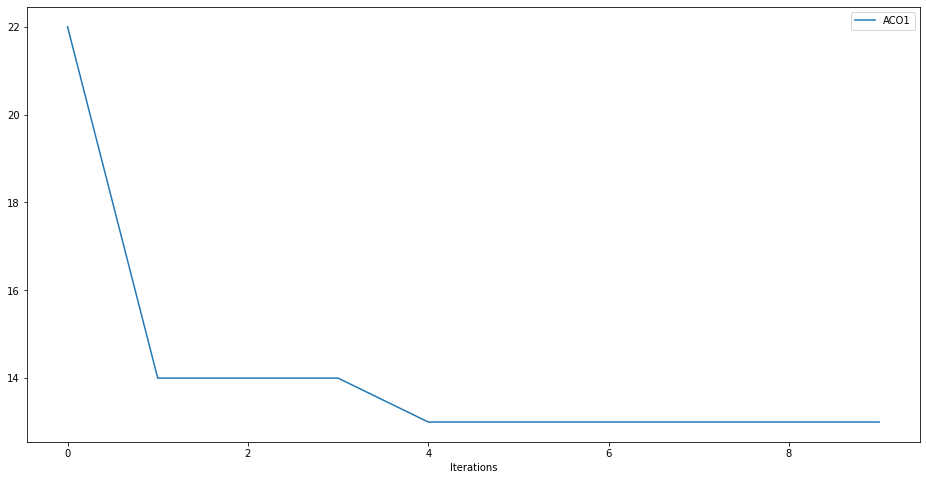

In [39]:
ax = hard_aco3.plot(x='Iterations', y='Violations', figsize=(16, 8), label="ACO1")
ax.legend(loc="upper right")

In [40]:
soft_aco3 = pd.DataFrame(aco3[0], columns=['Iterations', 'Violations'])


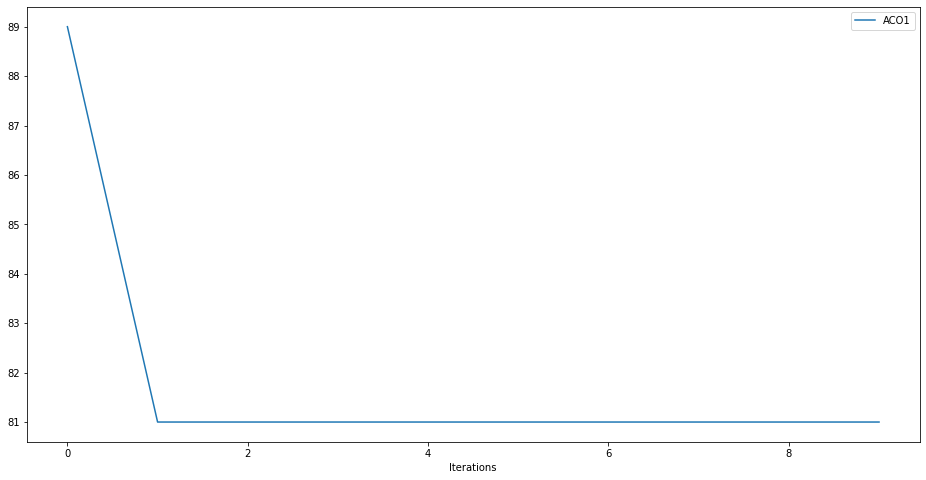

In [41]:
ax = soft_aco3.plot(x='Iterations', y='Violations', figsize=(16, 8), label="ACO1")
ax.legend(loc="upper right")

In [42]:
studentArr = []
for i in student_objects:
    for j in i.exams:
        roomArr = []
        capArr = []
        for k in list(j.rooms)[0]:
            roomArr.append(k.code)
            capArr.append(k.capacity)
        studentArr.append([i.code, j.code, j.slot.index, j.slot.day, j.slot.type, j.duration, len(j.students), roomArr,capArr])

In [43]:
pd.DataFrame(studentArr, columns=["student_code", "exam_code", "slot_index", "day", "type", "duration", "total_students", "rooms", "rooms_capacity" ]).to_csv('output_log/student_output_8.csv')

In [44]:
examArr = []
for i in exam_objects:
    roomArr = []
    capArr = []
    for j in list(i.rooms)[0]:
        roomArr.append(j.code)
        capArr.append(j.capacity)
    examArr.append([i.code, i.slot.index, i.slot.day, i.slot.type, i.duration, len(i.students), roomArr, capArr, i.access_requirement])

In [45]:
pd.DataFrame(examArr, columns=["exam_code", "slot_index", "day", "type", "duration", "total_students", "rooms", "rooms_capacity", "special_requirement" ]).to_csv('output_log/exam_output_8.csv')